In [1]:
import os
import random
import warnings
import numpy as np
import tensorflow as tf
from time import time
from Setting import setting
from Agent import AgentNetwork
from DataMovieLens import Dataset
from Environment import Environment  
from Recommender import RecommenderNetwork

import Utils as utils

'''
Code adapted from: https://github.com/jerryhao66/HRL
'''

global padding_number
global env
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # With '3' we hide INFO, WARNING and ERROR messages.
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
tf.get_logger().setLevel('INFO')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set the random seed for reproducibility.
random_seed = 42
tf.random.set_random_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
args = setting()
args.batch_size = 235
args.sep_test_users = False
args.windowed_dataset = True
args.null_values_model = "mf"
config = tf.ConfigProto()
dataset = Dataset(args.datapath, args.num_neg, args.batch_size, args.fast_running)
padding_number = dataset.num_items
pos_instances = dataset.get_positive_instances()
test_instances = dataset.get_test_instances()
pos_and_neg_instances = dataset.get_dataset_with_neg()
env = Environment(args, dataset)

c:\Users\gabri\OneDrive\Desktop\hrl paper\hrl_nr\DataMovieLens.py:367: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_user_input_list = np.array(p_user_input_list)


Epoch 0 : HR5 = 0.1678, NDCG5 = 0.1105, HR10 = 0.2687, NDCG10 = 0.1430, MAP = 0.1260, MRR = 0.1260, test loss = 0.4162 [31.0s] train_loss = 0.6436 [0.7s]
Epoch 3 : HR5 = 0.1827, NDCG5 = 0.1172, HR10 = 0.2952, NDCG10 = 0.1531, MAP = 0.1345, MRR = 0.1345, test loss = 0.2040 [33.4s] train_loss = 0.3443 [0.5s]
Epoch 6 : HR5 = 0.2006, NDCG5 = 0.1292, HR10 = 0.3178, NDCG10 = 0.1667, MAP = 0.1444, MRR = 0.1444, test loss = 0.1894 [30.8s] train_loss = 0.2930 [0.5s]
Epoch 9 : HR5 = 0.2096, NDCG5 = 0.1383, HR10 = 0.3363, NDCG10 = 0.1788, MAP = 0.1539, MRR = 0.1539, test loss = 0.1887 [31.2s] train_loss = 0.2533 [0.6s]
Recommender pretrain OK
Load best pre-trained recommender from  ./Checkpoint/pre-recommender/
Evaluate pre-trained recommender based on original test instances
Epoch -1 : HR5 = 0.2096, NDCG5 = 0.1383, HR10 = 0.3363, NDCG10 = 0.1788, MAP = 0.1539, MRR = 0.1539, test loss = 0.1887 [31.7s] train_loss = 0.0000 [0.0s]
pre-initialization environment
pre-train agent
pre-evaluation agent
E

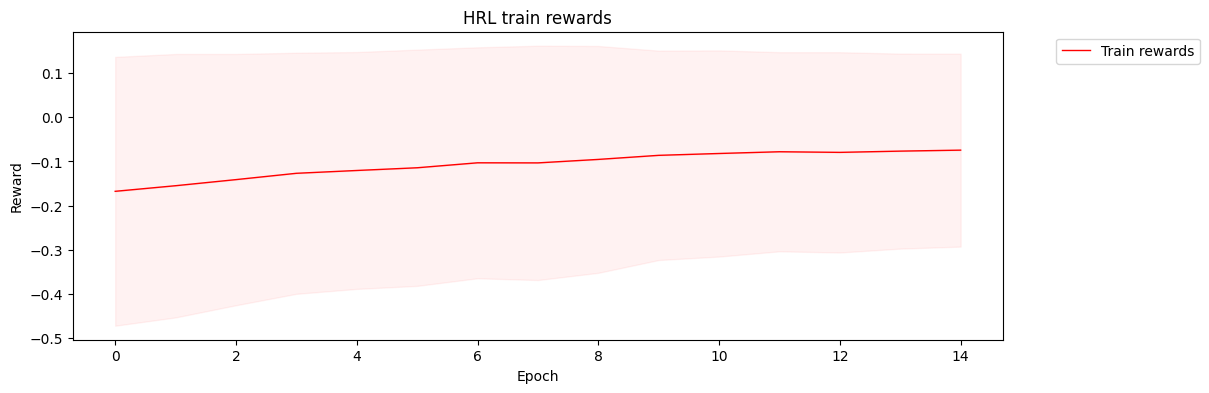

Evaluate jointly-trained recommender based on the selected test instances by the jointly-trained agent


100%|██████████| 13873/13873 [11:54<00:00, 19.42it/s]


Not revised profiles:  10274
Revised profiles:  3599
Deleted profiles:  0
Total RMSE: 0.5308 ± 0.3628
Explicit RMSE: 0.5304 ± 0.3629
Implicit RMSE: 1.1119 ± 0.6756
Epoch -1 : HR5 = 0.2127, NDCG5 = 0.1400, HR10 = 0.3401, NDCG10 = 0.1808, MAP = 0.1580, MRR = 0.1580, test loss = 0.1978 [837.1s] train_loss = 0.0000 [0.0s]
| Total time: 1750.883 s. | Train time: 575.783 s. | Test time: 1175.100 s. | 


In [4]:
train_times_list, test_times_list = [], []
train_avg_rewards_list, train_std_rewards_list = [], []
with tf.Session(config=config) as sess:
    recommender = RecommenderNetwork(sess, padding_number, args)
    agent = AgentNetwork(sess, args)
    pre_recommender_saver = tf.train.Saver()
    pre_agent_saver = tf.train.Saver()
    recommender_saver = tf.train.Saver()
    agent_saver = tf.train.Saver()    

    #Recommender pretrain
    if args.recommender_pretrain:
        best_ndcg10 = 0.0
        best_hr = 0.0
        sess.run(tf.global_variables_initializer())

        for epoch in range(args.recommender_epochs):
            train_begin = time()
            train_loss = utils.train(sess, agent, recommender, pos_and_neg_instances, 
                                     test_instances, args, env, padding_number, 
                                     recommender_trainable=True, agent_trainable=False)
            train_time = time() - train_begin
            train_times_list.append(train_time)
            recommender.assign_target_network()
            pos_and_neg_instances = dataset.get_dataset_with_neg()

            if epoch % args.recommender_verbose == 0:
                test_begin = time()
                (hr5, ndcg5, hr10, ndcg10, map, mrr, test_loss) = utils.evaluate(agent, recommender, test_instances, env, padding_number, noAgent=True)
                test_time = time() - test_begin
                test_times_list.append(test_time)
                utils.print_recommender_message("Epoch", epoch,hr5, ndcg5, hr10, ndcg10, map, mrr, test_loss, test_time, train_loss, train_time)
                if hr10 >=best_hr or ndcg10 >= best_ndcg:
                    best_hr = hr10
                    best_ndcg = ndcg10
                    pre_recommender_saver.save(sess, args.pre_recommender, global_step=epoch)
        print ("Recommender pretrain OK")
    print ("Load best pre-trained recommender from ", args.pre_recommender)
    pre_recommender_saver.restore(sess, tf.train.get_checkpoint_state(os.path.dirname(args.pre_recommender+'checkpoint')).model_checkpoint_path)
    print ("Evaluate pre-trained recommender based on original test instances")
    test_begin = time()
    (hr5, ndcg5, hr10, ndcg10, map, mrr, test_loss) = utils.evaluate(agent, recommender, test_instances, env, padding_number, noAgent=True)
    test_time = time() - test_begin
    test_times_list.append(test_time)
    utils.print_recommender_message("Epoch", -1, hr5, ndcg5, hr10, ndcg10, map, mrr, test_loss, test_time, 0, 0)

    #Agent pretrain
    print("pre-initialization environment")
    env.initilize_state(recommender, pos_instances, test_instances, args.high_state_size, args.low_state_size, padding_number)
    if args.agent_pretrain:
        best_avg_reward = -1000

        for epoch in range(args.agent_epochs):
            train_begin = time()
            print("pre-train agent")
            train_loss = utils.train(sess, agent, recommender, pos_instances, 
                                     test_instances, args, env, padding_number, 
                                     recommender_trainable=False, agent_trainable=True)
            train_time = time() - train_begin
            train_times_list.append(train_time)
            if epoch % args.agent_verbose == 0:
                test_begin = time()
                print("pre-evaluation agent")
                avg_reward, std_reward, total_selected_items, total_revised_instances,total_notrevised_instances, \
                    total_deleted_instances, total_keep_instances, test_time = utils.get_avg_reward(agent, pos_instances, test_instances, recommender, env, padding_number)
                test_time = time() - test_begin
                test_times_list.append(test_time)
                train_avg_rewards_list.append(avg_reward)
                train_std_rewards_list.append(std_reward)
                utils.print_agent_message(epoch, avg_reward, total_selected_items, total_revised_instances,total_notrevised_instances, total_deleted_instances,total_keep_instances,test_time,train_time)
                if avg_reward >= best_avg_reward:
                    best_avg_reward = avg_reward
                    pre_agent_saver.save(sess, args.pre_agent, global_step=epoch)
        print ("Agent pretrain OK")
    print ("Load best pre-trained agent from", args.pre_agent)
    pre_agent_saver.restore(sess, tf.train.get_checkpoint_state(os.path.dirname(args.pre_agent+'checkpoint')).model_checkpoint_path)

    #Agent and recommender jointly train
    print ("Begin to jointly train")
    best_ndcg10 = 0.0
    best_hr = 0.0
    best_avg_reward = -1000
    agent.udpate_tau(args.agent_tau)
    agent.update_lr(args.agent_lr)
    for epoch in range(0,5):
        train_begin = time()
        train_loss = utils.train(sess, agent, recommender, pos_instances, 
                                 test_instances, args, env, padding_number, 
                                 recommender_trainable=True, agent_trainable=True)
        train_time = time() - train_begin
        train_times_list.append(train_time)
        if epoch % 1 == 0:

            test_begin = time()
            avg_reward, std_reward, total_selected_items, total_revised_instances, total_notrevised_instances, \
                total_deleted_instances, total_keep_instances, test_time = utils.get_avg_reward(agent, pos_instances, test_instances, recommender, env, padding_number)
            test_time = time() - test_begin
            test_times_list.append(test_time)
            train_avg_rewards_list.append(avg_reward)
            train_std_rewards_list.append(std_reward)
            utils.print_agent_message(epoch, avg_reward, total_selected_items, total_revised_instances,total_notrevised_instances, total_deleted_instances,total_keep_instances,test_time,train_time)
            if avg_reward >= best_avg_reward:
                best_avg_reward = avg_reward
                agent_saver.save(sess, args.agent, global_step=epoch)

        env.initilize_state(recommender, pos_instances, test_instances, args.high_state_size, args.low_state_size, padding_number)
    print ("Jointly train OK")
    utils.print_train_rewards(train_avg_rewards_list, train_std_rewards_list)
    print ("Evaluate jointly-trained recommender based on the selected test instances by the jointly-trained agent")
    test_begin = time()
    (hr5, ndcg5, hr10, ndcg10, map, mrr, test_loss) = utils.evaluate(agent, recommender, test_instances, env, padding_number)
    test_time = time() - test_begin
    test_times_list.append(test_time)
    utils.print_recommender_message("Epoch", -1, hr5, ndcg5, hr10, ndcg10, map, mrr, test_loss, test_time, 0, 0)
    print("| Total time: {:5.3f} s. | Train time: {:5.3f} s. | Test time: {:5.3f} s. | ".
          format(np.sum(np.concatenate((train_times_list, test_times_list), axis=0)), 
                 np.sum(train_times_list), 
                 np.sum(test_times_list)))